### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/MyDrive/'
except Exception:
    data_dir = './data/'

In [2]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

In [123]:
!pip install ekphrasis gensim spacy nltk
!python -m spacy download 'en_core_web_sm'
!python -m spacy download 'en_core_web_lg'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 778.8 MB 10 kB/s  eta 0:00:0111     |███████████████████▍            | 470.5 MB 99.7 MB/s eta 0:00:04
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Loading Data

In [3]:
%%bash
export GENSIM_DATA_DIR='./data/'
# python -m gensim.downloader --download glove-twitter-25
# python -m gensim.downloader --download word2vec-google-news-300
# python -m gensim.downloader --download fasttext-wiki-news-subwords-300
# python -m gensim.downloader --download glove-twitter-100

In [121]:
import os
import re
import codecs

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import gensim
import gensim.downloader as api
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, random_split
from gensim.models import KeyedVectors

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.noslang.slangdict

In [5]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [397]:
# Load data
train_df = pd.read_csv(f'{data_dir}/train.csv')
test_df = pd.read_csv(f'{data_dir}/dev.csv')

In [398]:
train_df2 = pd.read_csv(f'{data_dir}/train_funlines.csv')

In [399]:
train_df = pd.concat([train_df, train_df2])
train_df.reset_index(inplace=True, drop=True)

In [400]:
train_df[-10:]

,id,original,edit,grades,meanGrade
17890,108238,How to block Facebook and Google from identify...,mistress,33221,2.2
17891,108239,How to block Facebook and Google from <identif...,mustaching,32221,2.0
17892,108240,Downtown Tokyo 's homeless fear <removal/> ahe...,Godzilla,32221,2.0
17893,108241,Israel signs pact to bar gay couples from adop...,Oligarchs,22100,1.0
17894,108242,Fear grips Chinese city as <virus/> lockdown b...,vampire,22222,2.0
17895,108243,Banning Facial <Recognition/> Is n’t Enough - ...,Cleansers,22222,2.0
17896,108244,Trump is reportedly threatening <Republicans/>...,children,21100,0.8
17897,108245,Peruvian indigenous group wins suit to block o...,Women,22110,1.2
17898,108246,Joe Rogan says he 's probably voting for <Bern...,Illuminati,22000,0.8
17899,108247,While Microsoft Was Making Its Climate Pledge ...,Spill,21111,1.2


In [401]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [354]:
train_df.describe()

,id,grades,meanGrade
count,17900.000000,1.790000e+04,17900.000000
mean,52043.866704,1.104498e+11,1.090601
std,48277.755973,6.030790e+12,0.596054
min,1.000000,0.000000e+00,0.000000
25%,6967.000000,2.000000e+04,0.600000
50%,14014.500000,2.211000e+04,1.000000
75%,103772.250000,3.210000e+04,1.600000
max,108247.000000,3.333332e+14,3.000000


### Analysing Data Distribution and Outliers

In [355]:
grade_std = train_df.meanGrade.std()
grade_mean = train_df.meanGrade.mean()
ub = grade_mean + grade_std * 3
lb = grade_mean - grade_std

train_df[(train_df['meanGrade'] > ub) | (train_df['meanGrade'] < lb)].count()

id           3361
original     3361
edit         3361
grades       3361
meanGrade    3361
dtype: int64

In [356]:
grade_std, grade_mean

(0.5960541095747479, 1.0906011108692673)

In [357]:
train_df[train_df['meanGrade'] >= 2.2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786 entries, 70 to 8238
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         786 non-null    int64  
 1   original   786 non-null    object 
 2   edit       786 non-null    object 
 3   grades     786 non-null    int64  
 4   meanGrade  786 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 36.8+ KB


In [358]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17900 entries, 0 to 8247
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         17900 non-null  int64  
 1   original   17900 non-null  object 
 2   edit       17900 non-null  object 
 3   grades     17900 non-null  int64  
 4   meanGrade  17900 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 839.1+ KB


In [359]:
train_df.meanGrade.unique()

array([0.2       , 1.6       , 1.        , 0.4       , 0.        ,
       1.2       , 0.8       , 1.4       , 0.6       , 1.8       ,
       2.2       , 2.        , 2.4       , 1.3       , 2.06666667,
       0.9       , 2.6       , 0.5       , 2.8       , 1.5       ,
       1.9       , 1.7       , 3.        , 1.1       , 0.7       ,
       2.13333333, 2.5       , 2.1       , 0.86666667, 2.3       ,
       0.3       , 1.33333333, 1.53333333, 1.375     , 1.28571429,
       1.83333333, 2.33333333, 0.83333333, 0.16666667, 1.66666667,
       2.16666667, 1.16666667, 0.66666667, 0.33333333, 0.57142857,
       1.42857143, 0.55555556, 0.85714286, 1.72727273, 2.125     ,
       1.14285714, 2.66666667, 1.45454545, 0.28571429, 1.18181818,
       1.85714286, 1.54545455])

In [360]:
train_df.meanGrade.value_counts().sort_index()

0.000000     676
0.166667       7
0.200000    1204
0.285714       1
0.300000       2
0.333333       9
0.400000    1458
0.500000      19
0.555556       1
0.571429       2
0.600000    1722
0.666667      14
0.700000       5
0.800000    1923
0.833333      26
0.857143       1
0.866667       1
0.900000       7
1.000000    2026
1.100000      13
1.142857       1
1.166667      36
1.181818       1
1.200000    2012
1.285714       2
1.300000      13
1.333333      47
1.375000       1
1.400000    1888
1.428571       4
1.454545       1
1.500000      57
1.533333       1
1.545455       1
1.600000    1667
1.666667      30
1.700000      11
1.727273       1
1.800000    1259
1.833333      29
1.857143       2
1.900000      10
2.000000     903
2.066667       1
2.100000       9
2.125000       1
2.133333       1
2.166667       8
2.200000     466
2.300000       3
2.333333       5
2.400000     213
2.500000       2
2.600000      73
2.666667       1
2.800000      19
3.000000       4
Name: meanGrade, dtype: int64

<AxesSubplot:>

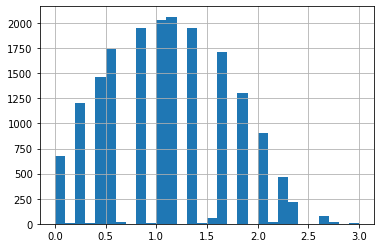

In [361]:
train_df.meanGrade.hist(bins=30)

In [362]:
def remove_outliers(df, ub):
    _df = df.copy()
    return _df[(_df.meanGrade <= ub)]

<AxesSubplot:>

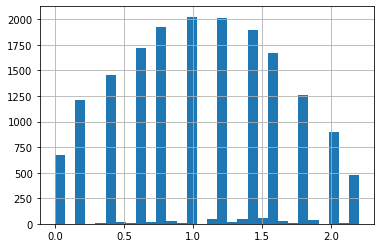

In [363]:
remove_outliers(train_df, ub=2.2).meanGrade.hist(bins=30)

### Preprocessing

In [364]:
nlp = spacy.load('en_core_web_lg')

In [19]:
print('GENSIM LIST OF WORD EMBEDDINGS')
api.info()['models'].keys()

GENSIM LIST OF WORD EMBEDDINGS


dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [16]:
model = KeyedVectors.load_word2vec_format('./data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz')

In [188]:
embeddings = model

#### Ekphrasis Preprocessor

In [22]:
text_processor = TextPreProcessor(
    annotate=['hashtag'],
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="english", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="english", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct=True,  # spell correction for elongated words
)

Reading english - 1grams ...
Reading english - 2grams ...


/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


#### Some Test Case

In [67]:
fancy_ascii_apostrophe = 0
apostrophe_s = 12
apostrophe_s_2 = 43
contraction_won_t = 48
contraction_won_t_2 = 264
punct_check = 50
contraction_isnt_2 = 66
hashtag = 425 
hashtag2 = 529 
punct_exclaim = 80
punct_question = 27
punct_dash = 26
contraction_dont = 128
contraction_hell = 131
punct_twitter_handle = 4388

test_sentences = [
    fancy_ascii_apostrophe,
    apostrophe_s,
    apostrophe_s_2,
    contraction_won_t,
    contraction_won_t_2,
    punct_check,
    contraction_isnt_2,
    hashtag,
    hashtag2, 
    punct_exclaim,
    punct_question,
    punct_dash,
    contraction_dont,
    contraction_hell,
    punct_twitter_handle,
]

In [68]:
train_df.loc[test_sentences]

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
12,7614,Trump 's 2nd Nominee for <Army/> Secretary Wit...,Class,22100,1.0
43,5732,Fox 's James Murdoch rebukes <Trump/> over Cha...,grits,10000,0.2
48,3274,Kelly wo n't commit to defending DACA in <cour...,space,33100,1.4
264,13786,Franken Reiterates He Wo n't <Resign/> : ' I K...,diet,31111,1.4
50,13443,Rand Paul : Saudi Arabia ’s Role in Backing <T...,Turpentine,10000,0.2
66,7780,This Is n't ' Another Watergate ' But It Plays...,Vaudeville,11000,0.4
425,13225,Steve Bannon <Meets/> with Billionaire Mercer ...,canoodles,21000,0.6
529,3636,China Is Attempting To <Muzzle/> #MeToo,start,0,0.0
80,8947,"Trump to Dems : Of course I colluded , big <de...",time,21000,0.6


#### Merging replacements in the original dataset

In [25]:
edited_sentences = train_df[['original', 'edit']] \
    .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1)
edited_sentences.head()

0    France is ‘ hunting down its citizens who join...
1    Pentagon claims 2,000 % increase in Russian tr...
2    Iceland PM Calls Snap Vote as Pedophile Furor ...
3    In an apparent first , Iran and Israel slap ea...
4    Trump was told weeks ago that Flynn misled sch...
dtype: object

#### Removing apostrophes

In [26]:
edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]

<ipython-input-26-649f357cc77e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]


0      France is ‘ hunting down its citizens who join...
12     Trump's 2nd Nominee for Class Secretary Withdraws
43     Fox's James Murdoch rebukes grits over Charlot...
48        Kelly won't commit to defending DACA in space 
50     Rand Paul : Saudi Arabia ’s Role in Backing Tu...
264    Franken Reiterates He Won't diet : ' I Know Th...
66     This Isn't ' Another Watergate ' But It Plays ...
dtype: object

#### Named Entity Recognition (NER)

Pretrained Word2Vec doesn't represent "france" and "France" in the same way (case sensitive). There are many named entities for which this happens which could be problematic if we want to utilities context sensitive representations.

In [135]:
from spacy import displacy 

def ner_viewer(sentence):
    trial_doc = nlp(sentence)

    for ent in trial_doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)

    displacy.render(trial_doc, style="ent", jupyter=True)

In [136]:
ner_viewer(sents.edited_sentences[0])
ner_viewer(sents.edited_sentences[1120])
ner_viewer(sents.edited_sentences[1477])

France 0 6 GPE
Iraq 74 78 GPE


Donald Trump 0 12 PERSON
Twitter 51 58 PRODUCT


Nobel Prize 30 41 WORK_OF_ART


In [47]:
# Analysing similiarty of vectors under google news embeddings
# top 10 similiarities

def similiarities(model, word1, word2, top_n=1000):
    top_words_list = model.similar_by_word(word1, topn=top_n)
    top_words_list2 = model.similar_by_word(word2, topn=top_n)
    top_words_set = set(w for w, sim in top_words_list)
    top_words_set2 = set(w for w, sim in top_words_list2)
    return top_words_list, top_words_list2, top_words_set.intersection(top_words_set2)

In [189]:
simlist1, simlist2, intersection = similiarities(embeddings, 'France', 'france')
intersection

{'-France',
 'AirFrance',
 'Belgium',
 'Belguim',
 'Boulogne',
 'Boulogne-Billancourt',
 'Bretagne',
 'Britain',
 'Britan',
 'Britanny',
 'Brittany',
 'Chateauroux',
 'Europe',
 'France-',
 'France.',
 'Franch',
 'Frence',
 'French',
 'Ile-de-France',
 'Italy',
 'Marseille',
 'Nimes',
 'Paris',
 'Poitou-Charentes',
 'Provence',
 'Spain',
 'Tarbes',
 'Versaille'}

In [190]:
simlist1, simlist2, intersection = similiarities(embeddings, 'Trump', 'trump')
print(simlist1[:10])
print()
print(simlist2[:10])

[('Trumps', 0.7959632873535156), ('Trumpian', 0.7332221269607544), ('Trumping', 0.7272778749465942), ('Trumpism', 0.7086310982704163), ('Drumpf', 0.7022296190261841), ('Trump-like', 0.6928916573524475), ('Anti-Trump', 0.6859002709388733), ('Trump-branded', 0.6830976009368896), ('Trumped', 0.6769288778305054), ('Trump-related', 0.6740255355834961)]

[('trumps', 0.8457010388374329), ('trumping', 0.7876768112182617), ('non-trump', 0.7490019798278809), ('trumped', 0.7124733328819275), ('notrump', 0.6544545888900757), ('supercede', 0.6326020956039429), ('overrule', 0.6288058757781982), ('no-trump', 0.6278952360153198), ('override', 0.6258442401885986), ('supersede', 0.6115215420722961)]


Trump has a different meaning to trump, where the first ones refers to the ex-President and the second is the verb. For this reason, in the context of headlines, we are safer capitalising all words that are named entities, when we are using news-specific pretrained embeddings.

In [31]:
# def tokenize(
#     data, 
#     is_lower=True, 
#     remove_stopwords=True, 
#     remove_puncts=True, 
#     remove_num=True, 
#     remove_currency=True
# ):
#     # Params for 
#     clean_text_param = {
#         "lower":False,                     # lowercase text
#         "no_line_breaks":True,           # fully strip line breaks as opposed to only normalizing them
#         "no_urls":False,                  # replace all URLs with a special token
#         "no_emails":False,                # replace all email addresses with a special token
#         "no_phone_numbers":False,         # replace all phone numbers with a special token
#         "no_numbers":False,               # replace all numbers with a special token
#         "no_digits":False,                # replace all digits with a special token
#         "no_currency_symbols":True,      # replace all currency symbols with a special token
#         "no_punct":True,                 # remove punctuations
#         "replace_with_punct":"",          # instead of removing punctuations you may replace them
#         "replace_with_number":"",
#         "replace_with_digit":"",
#         "replace_with_currency_symbol":"",
#         "lang":"en"                       # set to 'de' for German special handling
#     }

#     text_processor = TextPreProcessor(
#         annotate=['hashtag'],
#         fix_html=True,  # fix HTML tokens
        
#         # corpus from which the word statistics are going to be used 
#         # for word segmentation 
#         segmenter="english", 
        
#         # corpus from which the word statistics are going to be used 
#         # for spell correction
#         corrector="english", 
        
#         unpack_hashtags=True,  # perform word segmentation on hashtags
#         unpack_contractions=True,  # Unpack contractions (can't -> can not)
#         spell_correct=True,
#     )

#     tokenized_corpus = []

#     for sentence in data:

#         tokenized_sentence = []
#         # processed_sentence = text_processor.pre_process_doc(sentence)
#         # clean_sentence = clean(processed_sentence, **clean_text_param)
#         spacy_doc = nlp(sentence)

#         for token in spacy_doc:
#             processed_token = token
#             if (remove_stopwords and processed_token.is_stop):
#                 continue
#             elif (remove_puncts and processed_token.is_punct):
#               continue
#             elif (remove_num and processed_token.is_digit):
#               continue
#             elif (remove_currency and processed_token.is_currency):
#               continue
#             elif (is_lower):
#               tokenized_sentence.append(token.lower_)
#             else:
#               tokenized_sentence.append(token.text)

#         tokenized_corpus.append(tokenized_sentence)

#     return tokenized_corpus

In [59]:
import nltk
from nltk.corpus import stopwords

In [209]:
def capitalisation_by_ner(sentence, entities=['GPE', 'ORG', 'NORP', 'PERSON']):
    edited_row = []

    trial_doc = nlp(sentence)
        
    for tok in trial_doc:
        if tok.ent_type_ in entities:
            edited_row.append(tok.text)
        else:
            edited_row.append(tok.text.lower())
    
    return ' '.join(edited_row)

In [246]:
# Word replacement
# Join the contractions
# Tokenize
# remove stop words
# remove punct EXCEPT ! ? #
# Twitter handles

def preprocessor(df):
    _df = pd.DataFrame(index=df.index, columns=['edited_sentences', 'meanGrade'])

    _df['meanGrade'] = df.meanGrade

    text_processor = TextPreProcessor(
        fix_html=True,  # fix HTML tokens

        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="english", 

        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="english", 

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct=True,  # spell correction for elongated words
    )
    
    punct = "[\.,:;\(\)\[\]@\-\$£]"
    
    nltk.download('stopwords')
    stops = stopwords.words('english')

    # Word replacement + join the contractions
    # NOTE: need to deal with ' '
    # NOTE: Numbers/digits have not been removed
    # NOTE: We have removed all stop words. We analysed the sentiment of the stop 
    # words in the training set to determine if removing them would negatively 
    # affect our results. The motivation for this check was that any word with a 
    # sentiment would affect the funniness score of the sentence. 
    # Since stop words have no sentiment, they have been removed
    # This doesn't retain any twitter handles, but retains the hashtags

    _df['edited_sentences'] = df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1) \
        .apply(lambda x: capitalisation_by_ner(x)) \
        .str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one")) \
        .apply(lambda x: text_processor.pre_process_doc(x)) \
        .str.replace("#", "# ") \
        .str.replace("[‘’]", "'") \
        .str.replace("'s", "") \
        .str.replace(punct, "") \
        .apply(lambda x: " ".join([w for w in x.split(" ") if w not in stops])) \
        .str.replace("[0-9]", "")

    return _df

In [365]:
sents = preprocessor(train_df)
sents.loc[test_sentences]

Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-246-59b971d45cb7>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


,edited_sentences,meanGrade
0,France ' hunting citizens joined twins ' witho...,0.2
0,Donald Trump misunderstands G talks climate cr...,1.2
12,Trump nd nominee class secretary withdraws,1.0
12,bono drops Democratic presidential race,1.2
43,Fox James Murdoch rebukes grits Charlottesville,0.2
43,liberals say ' abandoned reason civility old ...,0.0
48,Kelly commit defending DACA space,1.4
48,' sociopathic disregard future ' trump epa se...,1.5
264,Franken reiterates diet ' know ' let lot peop...,1.4
264,distractions nfl mascot opens sexuality,1.4


#### Relationship between sentences length and mean grade

<AxesSubplot:title={'center':'length'}, xlabel='meanGrade'>

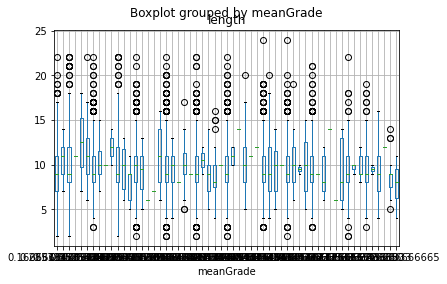

In [418]:
sentence_length = sents.edited_sentences.apply(lambda x: len(x.split(' ')))

plotter_df = pd.DataFrame(columns=['length', 'meanGrade'])
plotter_df.length = sentence_length
plotter_df.meanGrade = sents.meanGrade

plotter_df.boxplot('length', 'meanGrade')

### Checking cleaned corpus in embeddings

FastText embeddings from Gensim do not have common contractions such as "won't" and "don't" whereas Word2Vec do.

In [366]:
tokenized_words = sents.edited_sentences.map(lambda x: x.split(" "))
oov_words = []

for sentence in tokenized_words:
    for word in sentence:
        if word not in embeddings.vocab:
            oov_words.append(word)

In [367]:
from collections import Counter

oov_words_counter = Counter(oov_words)
print(oov_words_counter)

Counter({'': 16040, "n't": 300, "can't": 66, 'AT&T': 26, 'Sondland': 26, "he'll": 22, "they're": 21, 'Vindman': 16, 'Trumpcare': 15, 'soleimani': 15, 'metoo': 14, "we're": 13, "he'd": 12, 'TikTok': 12, 'mandalorian': 12, 'rosenstein': 11, 'ivanka': 11, 'manafort': 10, 'mulvaney': 10, "we'll": 9, 'danceoff': 9, 'amash': 9, 'grenfell': 8, 'parnas': 8, 'comey': 7, 'charlottesville': 7, 'usled': 7, 'AT&ampT': 7, 'manbun': 7, "DineshD'Souza": 6, 'Kushners': 6, 'glencore': 6, 'kaspersky': 6, 'nkorea': 6, "i'd": 6, 'Strzok': 6, 'cnnpoliticscom': 6, 'westworld': 6, 'trumpism': 6, 'rwc': 6, 'fortnite': 6, 'yovanovitch': 6, 'nunes': 6, 'Cybertruck': 6, 'apnewsbreak': 5, 'irma': 5, 'tillerson': 5, 'covfefe': 5, '`': 5, "BillO'Reilly": 5, 'degeneres': 5, 'coachella': 5, 'picchu': 5, "MartinO'Malley": 4, 'jinping': 4, 'sh*t': 4, 'gorsuch': 4, 'bigly': 4, "BetoO'Rourke": 4, 'tweetstorm': 4, 'Danceoff': 4, 'scorsese': 4, 'rogaine': 4, 'manbuns': 4, 'Zelenskiy': 4, 'USMCA': 4, 'dolittle': 4, 'Manassia

In [368]:
print(f'Matching success: {sum(oov_words_counter.values()) / len(tokenized_words)}')

Matching success: 0.9907262569832402


In [369]:
print("don't" in stopwords.words('english'))

True


In [242]:
stops = set(stopwords.words('english'))

In [243]:
corpus_words = set(" ".join(list(sents.edited_sentences)).split(" "))

In [ ]:
exceptions = []

In [ ]:
nltk.download('opinion_lexicon')

In [ ]:
from nltk.corpus import opinion_lexicon
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

In [244]:
inters = corpus_words.intersection(stops)
(inters)

{'a',
 'about',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 'its',
 'itself',
 'just',
 'm',
 'me',
 'more',
 'most',
 'my',
 'no',
 'nor',
 'not',
 'now',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'she',
 'should',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under'

In [370]:
# Proportion of training data for train compared to dev
train_proportion = 0.8

In [469]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            # print(feature)

            predictions = model(feature).squeeze(1)
            # print(predictions.shape)
            # print(predictions.mean(), predictions.std())

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [372]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item() * target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [373]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [374]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    
    for sentence in data:
        tokenized_sentence = []
        for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [375]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [465]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size,
                 device, stacks=1, lstm_dropout=0, bi=False):
        super(BiLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bi,
                            num_layers=stacks, dropout=lstm_dropout)

        # The linear layer that maps from hidden state space to tag space
        if bi:
            self.hidden_dim *= 2
            
        output_dims = 64
        
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_dim, output_dims),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(output_dims, output_dims),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(output_dims, 1),
        )
            
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim),
            self.hidden
        )

        out = self.fc(lstm_out[-1])
        # out = torch.distributions.transforms.ExpTransform()(out)
        return out

In [420]:
clean_train_df = preprocessor(train_df)
clean_test_df = preprocessor(test_df)

Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-246-59b971d45cb7>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [421]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = clean_train_df['edited_sentences']
test_data = clean_test_df['edited_sentences']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

Vocab created.


In [422]:
training_data.shape

(17900,)

In [466]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

index = 1

for word in joint_vocab:
    if word in embeddings.vocab:
        vec = embeddings.get_vector(word)
        wvecs.append(vec)
        word2idx.append((word, index))
        idx2word.append((index, word))
        index += 1

vector_dim = len(wvecs[0])
wvecs.insert(0, np.zeros(vector_dim))
wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [
    [word2idx[tok] for tok in seq if tok in word2idx]
    for seq in training_tokenized_corpus
]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

In [491]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]
BATCH_SIZE = 52
HIDDEN_DIM = 20

model = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM + 1,
               BATCH_SIZE, device, stacks=2, lstm_dropout=0.2)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.SmoothL1Loss(beta=0.2)
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Model initialised.
Dataloaders created.


In [492]:
model

BiLSTM(
  (embedding): Embedding(19128, 300, padding_idx=0)
  (lstm): LSTM(300, 20, num_layers=2, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [493]:
# Number of epochs
epochs = 100

train(train_loader, dev_loader, model, epochs)

Training model.
| Epoch: 01 | Train Loss: 1.09 | Train MSE: 1.76 | Train RMSE: 1.33 |         Val. Loss: 1.05 | Val. MSE: 1.67 |  Val. RMSE: 1.29 |
| Epoch: 02 | Train Loss: 1.04 | Train MSE: 1.65 | Train RMSE: 1.28 |         Val. Loss: 0.99 | Val. MSE: 1.55 |  Val. RMSE: 1.24 |
| Epoch: 03 | Train Loss: 0.98 | Train MSE: 1.51 | Train RMSE: 1.23 |         Val. Loss: 0.93 | Val. MSE: 1.40 |  Val. RMSE: 1.18 |
| Epoch: 04 | Train Loss: 0.90 | Train MSE: 1.34 | Train RMSE: 1.16 |         Val. Loss: 0.83 | Val. MSE: 1.20 |  Val. RMSE: 1.09 |
| Epoch: 05 | Train Loss: 0.79 | Train MSE: 1.10 | Train RMSE: 1.05 |         Val. Loss: 0.69 | Val. MSE: 0.91 |  Val. RMSE: 0.95 |
| Epoch: 06 | Train Loss: 0.63 | Train MSE: 0.78 | Train RMSE: 0.89 |         Val. Loss: 0.51 | Val. MSE: 0.57 |  Val. RMSE: 0.76 |
| Epoch: 07 | Train Loss: 0.49 | Train MSE: 0.52 | Train RMSE: 0.72 |         Val. Loss: 0.42 | Val. MSE: 0.39 |  Val. RMSE: 0.63 |
| Epoch: 08 | Train Loss: 0.44 | Train MSE: 0.43 | Train RMS

KeyboardInterrupt: 

##### Evaluating the model

In [475]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2419 non-null   int64  
 1   original     2419 non-null   object 
 2   edit         2419 non-null   object 
 3   grades       2419 non-null   int64  
 4   meanGrade    2419 non-null   float64
 5   predictions  2419 non-null   float32
 6   difference   2419 non-null   float32
 7   target       2419 non-null   float32
dtypes: float32(3), float64(1), int64(2), object(2)
memory usage: 123.0+ KB


In [476]:
vectorized_seqs_test = [
    [word2idx[tok] for tok in seq if tok in word2idx]
    for seq in test_tokenized_corpus
]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_test]

In [477]:
test_dataset = Task1Dataset(vectorized_seqs_test, test_df['meanGrade'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

In [478]:
loss, mse, predictions, target = eval(test_loader, model)
model_performance(predictions, target, print_output=True)

| MSE: 0.36 | RMSE: 0.60 |


(861.8911, 0.3563006)

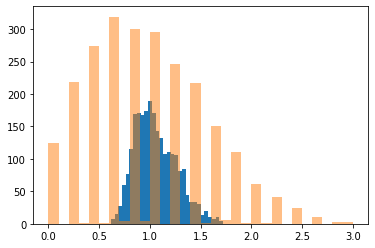

In [479]:
import matplotlib.pyplot as plt

plt.hist(predictions, bins=30)
plt.hist(target, bins=30, alpha=0.5)
plt.show()

In [480]:
from sklearn.metrics import explained_variance_score, r2_score

In [481]:
explained_variance_score(target, predictions)

-0.019822239875793457

In [482]:
r2_score(target, predictions)

-0.06502799107346013

In [483]:
print(min(predictions))
print(max(predictions))
rounded_preds = np.round_(predictions, decimals=1)
print(min(rounded_preds))
print(max(rounded_preds))

0.61464137
1.7208139
0.6
1.7


In [484]:
diff = abs(predictions - target)
test_df['predictions'] = predictions
test_df['difference'] = diff
test_df['target'] = target
results_df = test_df[diff > 0.5][['original', 'edit', 'meanGrade', 'predictions', 'target', 'difference']]
results_df

,original,edit,meanGrade,predictions,target,difference
2,Spanish police detain man and search Ripoll ad...,squad,0.6,1.147781,0.6,0.547781
4,Vladimir Putin Releases Video Simulation Of Ru...,balloon,0.4,1.375476,0.4,0.975476
5,"Ex-Goldman Sachs boss , Obama ambassador Murph...",chase,0.4,1.395656,0.4,0.995656
10,Trump Fundraiser 's Email Breach Shows <Risks/...,Brunch,0.4,0.965778,0.4,0.565778
11,White House blasts <request/> from China as ' ...,ice,0.4,0.941441,0.4,0.541441
...,...,...,...,...,...,...
2408,Trump Orders Agencies To Reduce <Regulations/>,volumes,0.4,0.950063,0.4,0.550063
2410,Trump enjoys a week without a <crisis/>,carbohydrates,1.6,0.990703,1.6,0.609297
2411,The Guardian view on Trump and Israel : stick ...,brownie,0.4,1.084576,0.4,0.684576
2414,Supreme <Court/> Once Again Strikes Down Racia...,leaders,0.2,0.780459,0.2,0.580459


In [485]:
for i in range(1):
    index = results_df.index[i]
    print(results_df['original'][index], " | ", results_df['edit'][index], " | ", results_df['meanGrade'][index], results_df['predictions'][index])

Spanish police detain man and search Ripoll addresses in hunt for terror <suspects/>   |  squad  |  0.6 1.1477813


In [486]:
np.var(target - predictions)

0.3411772

<AxesSubplot:>

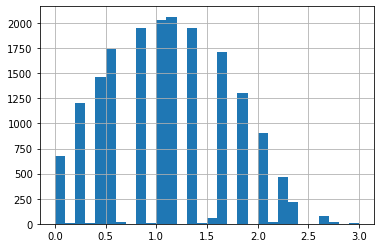

In [487]:
train_df['meanGrade'].hist(bins=30)

<AxesSubplot:>

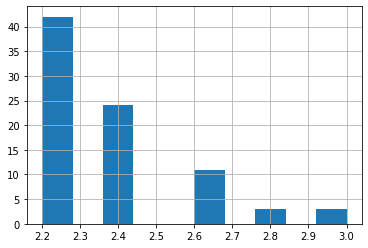

In [488]:
test_df[test_df['meanGrade'] >= 2.2]['meanGrade'].hist()

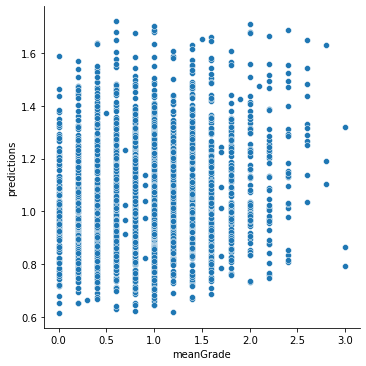

In [489]:
import seaborn as sns

sns.relplot(x='meanGrade', y='predictions', data=test_df)

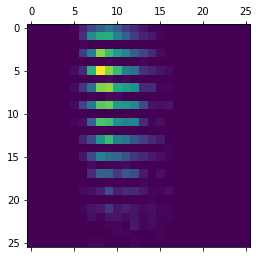

In [490]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(target * 10, rounded_preds * 10)
plt.matshow(conf)

In [334]:
print(classification_report(target * 10, rounded_preds * 10))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       124
         2.0       0.00      0.00      0.00       218
         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00       274
         5.0       0.00      0.00      0.00         1
         6.0       0.16      0.05      0.08       319
         7.0       0.00      0.00      0.00         4
         8.0       0.12      0.19      0.15       300
         9.0       0.00      0.00      0.00         5
        10.0       0.12      0.14      0.13       296
        11.0       0.00      0.00      0.00         0
        12.0       0.09      0.06      0.07       246
        13.0       0.00      0.00      0.00         0
        14.0       0.16      0.06      0.09       217
        15.0       0.00      0.00      0.00         1
        16.0       0.04      0.01      0.01       150
        17.0       0.00      0.00      0.00         6
        18.0       0.08    

/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [335]:
train_and_dev_loader = torch.utils.data.DataLoader(train_and_dev, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

In [336]:
loss_t, mse_t, predictions_t, target_t = eval(train_and_dev_loader, model)
model_performance(predictions_t, target_t, print_output=True)

| MSE: 0.25 | RMSE: 0.50 |


(2438.09, 0.25259948)

In [337]:
diff_t = abs(predictions_t - target_t)
train_eval_df = train_df.copy(deep=True)
train_eval_df['predictions'] = predictions_t
train_eval_df['difference'] = diff_t
train_eval_df['target'] = target_t

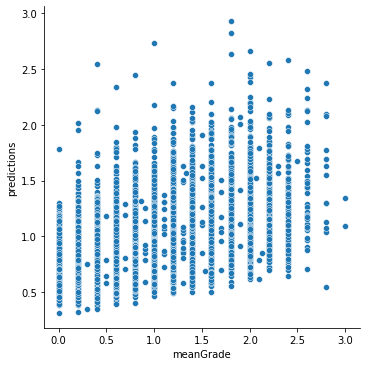

In [338]:
sns.relplot(x='meanGrade', y='predictions', data=train_eval_df)

<AxesSubplot:title={'center':'predictions'}, xlabel='[meanGrade]'>

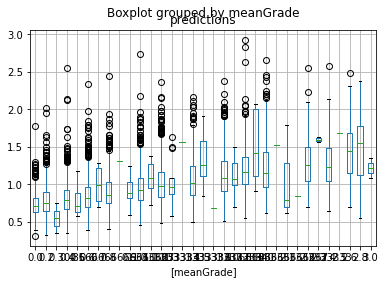

In [339]:
train_eval_df[['meanGrade', 'predictions']].boxplot(by='meanGrade')

In [287]:
low_grade = train_eval_df[(train_eval_df['meanGrade'] < 0.3) & (train_eval_df['difference'] >= 1.0)]
low_grade

,id,original,edit,grades,meanGrade,predictions,difference,target
190,2883,Is the Senate <filibuster/> of Gorsuch really ...,laziness,10000,0.2,1.344123,1.144123,0.2
267,770,TRUMP <FUMES/> AT MUELLER AFTER COHEN RAID : '...,LAUGHS,0,0.0,1.168607,1.168607,0.0
269,12059,How <America/> feels about Trump,marshmallow,10000,0.2,1.287891,1.087891,0.2
429,5311,Shocking <scale/> of US drinking water crisis,bottle,10000,0.2,1.432445,1.232445,0.2
578,10727,Bill Maher : “ I <doubt/> that Trump will be p...,hope,10000,0.2,1.236855,1.036855,0.2
579,4246,The Russian government is giving up control of...,Weather,10000,0.2,1.214815,1.014815,0.2
863,7907,When a Holocaust <denier/> chooses to run for ...,survivor,0,0.0,1.122697,1.122697,0.0
1263,5771,<Trump/> Rally : Why it 's misunderstood and ...,Casserole,10000,0.2,1.776996,1.576996,0.2
1352,877,Where 's Zuck ? Facebook CEO silent as data ha...,progresses,0,0.0,1.483834,1.483834,0.0
1367,14706,Russia elected Trump while U.S. <spies/> ' sle...,kittens,10000,0.2,1.548965,1.348965,0.2


#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)